<a href="https://colab.research.google.com/github/Hamza80saidi/AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection/blob/main/projetarabert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 1️⃣ Installation des dépendances
# ============================================================
!pip install transformers datasets arabert scikit-learn matplotlib seaborn pyarrow

# ============================================================
# 2️⃣ Imports
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.6 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=6f8080ee41f0f94483f7fae652d256fe023d84d3aeffc7c0ee445dc78e267dd1
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
# ============================================================
# 3️⃣ Chargement du dataset depuis ton fichier Parquet
# ============================================================
!pip install datasets

from datasets import load_dataset

# Charger directement depuis Hugging Face
dataset = load_dataset("KFUPM-JRCAI/arabic-generated-social-media-posts")
df_raw = dataset['train'].to_pandas()

print("Colonnes disponibles :", df_raw.columns)
print(df_raw.head())


Colonnes disponibles : Index(['original_post', 'allam_generated_post', 'jais_generated_post',
       'llama_generated_post', 'openai_generated_post'],
      dtype='object')
                                       original_post  \
0  هنا الكثير من منيف، والكثير من شرق المتوسط أيض...   
1  الطلياني شكري المبخوت. شكري المبخوت هو كاتب تو...   
2  نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...   
3  لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...   
4  من هو "يوسف زيدان"؟. أتراه متشكك فى كل العقائد...   

                                allam_generated_post  \
0  هنا الكثير من منيف، والكثير من شرق المتوسط أيض...   
1  الطلياني شكري المبخوت هو كاتب تونسي ورئيس جامع...   
2  نهاية فؤاد حداد تتجلى في هذا الديوان، صور تعبي...   
3  لماذا يحب التاريخ أن يعيد نفسه في الدول المتخل...   
4  من هو "يوسف زيدان"؟ أتراه متشكك في كل العقائد،...   

                                 jais_generated_post  \
0  هنا الكثير من منيف، والكثير من شرق المتوسط أيض...   
1  شكري المبخوت هو كاتب تونسي ورئيس جامعة

In [ ]:
import pandas as pd

# Création du DataFrame pour classification binaire
df_binary = pd.DataFrame({
    'text': list(df_raw['original_post']) +
            list(df_raw['allam_generated_post']) +
            list(df_raw['jais_generated_post']) +
            list(df_raw['llama_generated_post']) +
            list(df_raw['openai_generated_post']),
    'label': ['human'] * len(df_raw) +
             ['ai'] * (4 * len(df_raw))
})

# Suppression des lignes vides
df_binary.dropna(subset=['text'], inplace=True)


 3. Séparation entraînement / test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_binary['text'], df_binary['label'],
    test_size=0.2, random_state=42, stratify=df_binary['label']
)


 4. Extraction des embeddings avec AraBERT

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Charger AraBERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")
model.eval()

def get_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)

X_train_emb = get_embeddings(X_train)
X_test_emb = get_embeddings(X_test)


100%|██████████| 3318/3318 [22:26<00:00,  2.46it/s]


5. Entraînement des modèles classiques

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_emb, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_emb, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

6.Evaluation

SVM Classification Report:
              precision    recall  f1-score   support

          ai       0.91      0.93      0.92      2654
       human       0.68      0.61      0.64       664

    accuracy                           0.86      3318
   macro avg       0.79      0.77      0.78      3318
weighted avg       0.86      0.86      0.86      3318

Random Forest Classification Report:
              precision    recall  f1-score   support

          ai       0.85      0.94      0.89      2654
       human       0.56      0.31      0.40       664

    accuracy                           0.81      3318
   macro avg       0.70      0.63      0.65      3318
weighted avg       0.79      0.81      0.79      3318



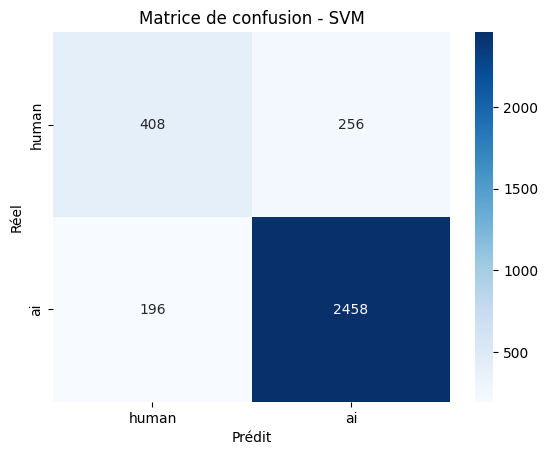

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# SVM
y_pred_svm = svm_model.predict(X_test_emb)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Random Forest
y_pred_rf = rf_model.predict(X_test_emb)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm, labels=['human', 'ai'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['human', 'ai'], yticklabels=['human', 'ai'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - SVM")
plt.show()


## fine-tuning complet de AraBERT





In [ ]:
!pip install datasets transformers arabert PyArabic farasapy evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=8d6e8ca3c926a6bc87ef909efe52d6d14c33fc6574140770e116b371885364e1
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
# Partie 0 — Chargement (copie/colle et exécute d'abord)
!pip install -q datasets pyarrow

from datasets import load_dataset
import pandas as pd
import os, sys

df_raw = None

# 1) Essayer de charger depuis Hugging Face (préférable)
try:
    dataset = load_dataset("KFUPM-JRCAI/arabic-generated-social-media-posts")
    df_raw = dataset['train'].to_pandas()
    print("Chargé depuis Hugging Face : dataset['train'] -> df_raw")
except Exception as e:
    print("load_dataset a échoué :", repr(e))
    # 2) Si échec, tenter de charger un parquet local (chemin par défaut indiqué précédemment)
    local_path = "/content/sample_data/train-00000-of-00001.parquet"
    if os.path.exists(local_path):
        try:
            df_raw = pd.read_parquet(local_path)
            print(f"Chargé depuis le fichier local : {local_path}")
        except Exception as e2:
            print("Lecture du parquet local a échoué :", repr(e2))
            raise RuntimeError("Impossible de charger le dataset ni depuis HF ni depuis le fichier local. Vérifie le fichier parquet.") from e2
    else:
        raise RuntimeError("Aucun fichier local trouvé et load_dataset a échoué. Vérifie ta connexion ou upload le fichier parquet dans /content/sample_data/.")

# Afficher colonnes et 2 exemples pour vérifier la structure
print("\nColonnes trouvées :", list(df_raw.columns))
print("\nAperçu (2 premières lignes) :")
display(df_raw.head(2))


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/43.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3318 [00:00<?, ? examples/s]

Chargé depuis Hugging Face : dataset['train'] -> df_raw

Colonnes trouvées : ['original_post', 'allam_generated_post', 'jais_generated_post', 'llama_generated_post', 'openai_generated_post']

Aperçu (2 premières lignes) :


,original_post,allam_generated_post,jais_generated_post,llama_generated_post,openai_generated_post
0,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...,هنا الكثير من منيف، والكثير من شرق المتوسط أيض...
1,الطلياني شكري المبخوت. شكري المبخوت هو كاتب تو...,الطلياني شكري المبخوت هو كاتب تونسي ورئيس جامع...,شكري المبخوت هو كاتب تونسي ورئيس جامعة منوبة ا...,الطلياني شكري المبخوت. شكري المبخوت هو كاتب تو...,شكري المبخوت، الكاتب التونسي البارز، ورئيس جام...


In [ ]:
import pandas as pd

def flatten_cell(x):
    if isinstance(x, list):
        for s in x:
            if isinstance(s, str) and s.strip():
                return s.strip()
        return ""
    elif isinstance(x, str):
        return x.strip()
    else:
        return ""

human_col = 'original_post'
ai_cols = ['allam_generated_post', 'jais_generated_post', 'llama_generated_post', 'openai_generated_post']

human_texts = []
if human_col in df_raw.columns:
    human_texts = [flatten_cell(x) for x in df_raw[human_col].dropna().tolist()]

ai_texts = []
for c in ai_cols:
    if c in df_raw.columns:
        ai_texts.extend([flatten_cell(x) for x in df_raw[c].dropna().tolist()])

texts = human_texts + ai_texts
labels = [0]*len(human_texts) + [1]*len(ai_texts)

df = pd.DataFrame({'text': texts, 'label': labels})
df['text'] = df['text'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df = df[df['text'].str.len() > 20].drop_duplicates(subset='text').reset_index(drop=True)

print("Après nettoyage :", df.shape)
print(df['label'].value_counts())


Après nettoyage : (16530, 2)
label
1    13212
0     3318
Name: count, dtype: int64


In [ ]:
# Partie 2 — Conversion DataFrame -> Dataset + Split
from datasets import Dataset

# Conversion du DataFrame pandas en Dataset Hugging Face
dataset_hf = Dataset.from_pandas(df)

# Split en train / validation / test
dataset_split = dataset_hf.train_test_split(test_size=0.2, seed=42)
test_valid_split = dataset_split['test'].train_test_split(test_size=0.5, seed=42)

train_ds = dataset_split['train']
val_ds   = test_valid_split['train']
test_ds  = test_valid_split['test']

print("Train size :", len(train_ds))
print("Val size   :", len(val_ds))
print("Test size  :", len(test_ds))


Train size : 13224
Val size   : 1653
Test size  : 1653


In [ ]:
# Partie 3 — Tokenisation
from transformers import AutoTokenizer

# Charger le tokenizer AraBERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

# Fonction de prétraitement
def preprocess_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

# Application du tokenizer sur chaque split
train_tok = train_ds.map(preprocess_fn, batched=True)
val_tok   = val_ds.map(preprocess_fn, batched=True)
test_tok  = test_ds.map(preprocess_fn, batched=True)


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/13224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import torch

# Vérification du déséquilibre
labels_list = train_ds['label']
unique, counts = np.unique(labels_list, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Répartition des classes :", class_counts)

# Calcul des poids inverses
total_samples = sum(counts)
class_weights = [total_samples / (len(unique) * c) for c in counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")
print("Poids de classes :", class_weights)


Répartition des classes : {np.int64(0): np.int64(2630), np.int64(1): np.int64(10594)}
Poids de classes : tensor([2.5141, 0.6241], device='cuda:0')


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import BertForSequenceClassification

# Charger le modèle AraBERT
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2",
    num_labels=2
).to("cuda")

# Redéfinition du calcul de perte pour intégrer les poids
from torch.nn import CrossEntropyLoss

def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Lancer le fine-tuning

In [ ]:
from transformers import TrainingArguments, Trainer
!pip install evaluate
import evaluate

In [ ]:
from transformers import TrainingArguments, Trainer
import evaluate
import torch
from torch.nn import CrossEntropyLoss

# Définition des métriques
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {**acc, **f1}

# Subclass Trainer to use custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Création du Trainer personnalisé
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1469889490.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
trainer.train()
trainer.save_model("./best_arabert_model")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saidihamza (saidihamza-fp-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.319500,0.347540,0.856019,0.865706
2,0.290600,0.399177,0.867514,0.874566
3,0.256800,0.488969,0.865699,0.871615


In [ ]:
metrics = trainer.evaluate(test_tok)
print("Résultats sur le test :", metrics)


Résultats sur le test : {'eval_loss': 0.36260753870010376, 'eval_accuracy': 0.852389594676346, 'eval_f1': 0.85899409569313, 'eval_runtime': 11.5806, 'eval_samples_per_second': 142.739, 'eval_steps_per_second': 8.981, 'epoch': 3.0}


In [ ]:
# ===== Gradio : interface de prédiction IA vs Humain =====
!pip install -q gradio

import re
import torch
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import os

# 1) Chemin du modèle fine-tuné (modifie si tu as un autre dossier)
# Find the latest checkpoint directory
results_dir = "./results"

if not os.path.exists(results_dir):
    print(f"Error: The directory '{results_dir}' was not found. Please ensure the training cell (cell ID vcQPijrUBPXm) was executed successfully and created this directory.")
else:
    checkpoints = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d)) and d.startswith("checkpoint-")]
    if not checkpoints:
        print(f"Error: No checkpoint directories found in '{results_dir}'. Please ensure the training cell (cell ID vcQPijrUBPXm) completed successfully.")
    else:
        checkpoints.sort(key=lambda x: int(x.split("-")[1]))
        MODEL_DIR = os.path.join(results_dir, checkpoints[-1]) if checkpoints else "./best_arabert_model"


        # 2) Chargement modèle + tokenizer (GPU si dispo)
        device = 0 if torch.cuda.is_available() else -1
        tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

        pipe = TextClassificationPipeline(
            model=model,
            tokenizer=tokenizer,
            device=device,
            return_all_scores=True,   # on veut les scores de TOUTES les classes
            truncation=True,
            padding=True
        )

        # 3) Petit normaliseur arabe (léger, non destructif)
        _ARABIC_NORM_MAP = {
            "أ": "ا", "إ": "ا", "آ": "ا",
            "ى": "ي", "ؤ": "و", "ئ": "ي",
        }
        def normalize_ar(text: str) -> str:
            if not isinstance(text, str):
                return ""
            text = text.strip()
            # normalisation légère des lettres
            for k, v in _ARABIC_NORM_MAP.items():
                text = text.replace(k, v)
            # compresser espaces
            text = re.sub(r"\s+", " ", text)
            return text

        # 4) Mapping des labels du modèle -> libellés lisibles
        #    IMPORTANT : on suppose label 0 = humain, label 1 = IA (comme dans ton entraînement)
        id2name = {0: "Humain", 1: "IA"}

        def predict(text: str):
            text = normalize_ar(text)
            if not text or len(text) < 5:
                return {"Humain": 0.0, "IA": 0.0}, "⚠️ Entrez un texte plus long."

            # pipeline retourne une liste: [[{'label':'LABEL_0','score':...}, {'label':'LABEL_1','score':...}]]
            scores = pipe(text)[0]

            # réorganiser en dict {Humain: p, IA: p}
            probs = {}
            for item in scores:
                # convertir 'LABEL_0' -> 0, etc.
                idx = int(item["label"].split("_")[-1])
                name = id2name.get(idx, item["label"])
                probs[name] = float(item["score"])

            # verdict lisible
            top_label = max(probs, key=probs.get)
            top_score = probs[top_label] * 100.0
            verdict = f"**Prédiction : {top_label} ({top_score:.2f}%)**"

            # gr.Label attend un dict {classe: prob}
            return probs, verdict

        # 5) Interface Gradio
        with gr.Blocks(title="Détection de texte arabe : IA vs Humain") as demo:
            gr.Markdown("## Détection du texte arabe — IA vs Humain\n"
                        "Entrez un texte en arabe, le modèle AraBERT fine-tuné prédit s il est **IA** ou **Humain** avec un pourcentage.")
            with gr.Row():
                txt = gr.Textbox(label="Texte en arabe", lines=6, placeholder=" ألصق نصًا بالعربية هنا...")
            with gr.Row():
                btn = gr.Button("Prédire")
            with gr.Row():
                out_scores = gr.Label(label="Probabilités (plus haut = plus probable)")
            with gr.Row():
                out_verdict = gr.Markdown()

            examples = [
                "هذا النص تمت كتابته بواسطة إنسان ويحمل أسلوباً شخصياً واضحاً.",
                "اكتب مقالاً عن فوائد القراءة وتأثيرها على تطوير الذات بلغة عربية فصحى.",
                "أشعر اليوم ببعض القلق لكنني سأحاول التركيز على عملي وإنهاء المهام المطلوبة."
            ]
            gr.Examples(examples=examples, inputs=[txt])

            btn.click(fn=predict, inputs=[txt], outputs=[out_scores, out_verdict])

        # 6) Lancement (share=True pour lien public temporaire depuis Colab)
        demo.launch(share=False)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [2]:
!git clone https://github.com/Hamza80saidi/AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection

Cloning into 'AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [9]:
cd AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection


[Errno 2] No such file or directory: 'AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection'
/content/AraBERT-Fine-Tuning-for-Arabic-AI-Text-Detection


In [11]:
!ls

README.md
